In [1]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [2]:
import torch
import random
import numpy as np
import pandas as pd
import copy
from datasets import load_from_disk
from transformers import TrainingArguments, Trainer, AutoProcessor, AutoModelForCTC
from torch.nn.utils import clip_grad_norm_
from collections import defaultdict
from opacus.accountants import RDPAccountant
import matplotlib.pyplot as plt
import os
import utils
from utils import *

import matplotlib.pyplot as plt

random.seed(217)
np.random.seed(217)

In [5]:
processor = AutoProcessor.from_pretrained("/scratch/pippalin2/jupyter/GMM-DistilHuBERT/processor")
base_model = AutoModelForCTC.from_pretrained("ntu-spml/distilhubert").to("cuda")
utils.processor = processor

Some weights of HubertForCTC were not initialized from the model checkpoint at ntu-spml/distilhubert and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
dataset = load_from_disk("/scratch/pippalin2/jupyter/GMM-DistilHuBERT/processed_dataset")
dataset = dataset.train_test_split(test_size=0.1, seed=217)
train_dataset = dataset["train"]
eval_dataset = dataset["test"]
client_datasets = split_into_clients_nonuniform(train_dataset, num_clients=20, min_frac=0.01, max_frac=0.1)

data_collator = DataCollatorCTCWithPadding(processor)
model_save_path = "/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/DP_FedAvg_checkpoints"

Loading dataset from disk:   0%|          | 0/47 [00:00<?, ?it/s]

#### Hyper-parameter value (z, S, Wmin):
* empirically estimate the L2 norm of the model update produced by each client in one round, to choose a proper clipping bound S: keep most of the $\Delta_k$ unchanged.

In [5]:
norms = []

for client_data in client_datasets:  # All 20 clients
    local_model = copy.deepcopy(base_model)
    before = copy.deepcopy(local_model.state_dict())

    after, _ = local_finetune(local_model, client_data, processor, data_collator, compute_metrics, model_save_path)
    delta = {k: after[k] - before[k] for k in before}
    flat = torch.cat([v.flatten() for v in delta.values()])
    norms.append(torch.norm(flat).item())

/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2278.628500
20,1144.216600
30,1103.275000
40,1052.447200
50,1015.152300
60,984.246300
70,1055.685500
80,1074.428100
90,1033.252100
100,1081.136500


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2200.529700
20,1093.260400
30,1051.110300
40,1067.975900
50,1065.988000
60,1089.944200
70,1032.003900
80,1032.986200
90,1072.169000
100,1044.296700


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2162.903900
20,1181.832700
30,1038.874400
40,1020.803100
50,1135.995300
60,1006.399300
70,1058.906300
80,1047.636700
90,1013.818200
100,1063.605100


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2269.003300
20,1143.165500
30,1067.895600
40,1000.734100
50,1053.445400
60,1006.359800
70,1030.532300
80,1094.851600
90,1048.700600
100,1088.712900


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2243.712700
20,1151.095400
30,1115.544200
40,1082.879200
50,1011.391800
60,1062.577900
70,1117.969200
80,1044.837500
90,1093.452800
100,1109.414700


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2278.649400
20,1170.219700
30,1087.812700
40,1048.041600
50,1086.171100
60,1055.977000
70,1044.291900
80,1107.385800
90,1062.055900
100,1079.121200


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2243.164100
20,1130.101600
30,1032.673500
40,1028.298300
50,1057.129100
60,1080.059300
70,1046.166600
80,1019.729600
90,1094.730600
100,1024.452300


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2247.578700
20,1170.044300
30,1056.201800
40,1073.385800
50,1052.497800
60,1057.321300
70,1042.739100
80,1032.578500
90,1010.634400
100,1063.981900


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2301.520500
20,1160.449900
30,1115.129900
40,1057.689800
50,1058.807700
60,1015.838400
70,1006.851900
80,1023.458500
90,1105.488500
100,1055.515100


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2193.985200
20,1153.740300
30,1077.585100
40,1078.425500
50,1111.205000
60,993.356500
70,1083.943300
80,1056.496000
90,1033.819200
100,1112.727900


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2175.849200
20,1138.301500
30,1097.893700
40,1061.574700
50,1084.043800
60,996.927000
70,1059.913100
80,1006.405000
90,1038.862600
100,1077.247200


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2288.603500
20,1191.091500
30,1008.528400
40,1012.231500
50,1085.927500
60,1097.183000
70,1079.750400
80,1118.184000
90,1083.171300
100,1027.008500


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2220.301400
20,1092.071400
30,1098.159800
40,1105.086700
50,1082.195700
60,1086.683800
70,1063.656000
80,1058.314800
90,982.816800
100,1020.080500


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2304.746900
20,1130.939300
30,1132.094700
40,1013.416900
50,1115.391500
60,1099.364200
70,1051.377000
80,1057.496500
90,1045.464700
100,999.423800


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2226.326600
20,1041.852000
30,1074.542000
40,1087.725700
50,1118.395500
60,1045.595600
70,1104.390300
80,1066.885900
90,1090.555600
100,1114.936300


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2359.310500
20,1114.669900
30,1112.593800
40,1112.072900
50,1143.227500
60,1114.233600
70,1080.398700
80,997.430200
90,1083.573500
100,996.129600


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2229.391000
20,1091.852000
30,1141.314300
40,1044.908400
50,1009.023700
60,1116.279900
70,952.585100
80,955.172000
90,1124.577500
100,985.365300


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2326.129100
20,1123.403500
30,1158.883700
40,1015.120700
50,1074.834000
60,1016.970500
70,1014.769000
80,1070.293400
90,1076.498900
100,1099.438100


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2105.951800
20,1212.677100
30,1084.397900
40,1086.717600
50,1009.224900
60,1107.418600
70,1065.526100
80,1028.965800
90,1043.594800
100,1053.422900


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2173.363900
20,1112.219900
30,1093.858400
40,1079.545700
50,1103.813600
60,1047.995000
70,1027.605700
80,996.229700
90,1105.117200
100,1111.891600


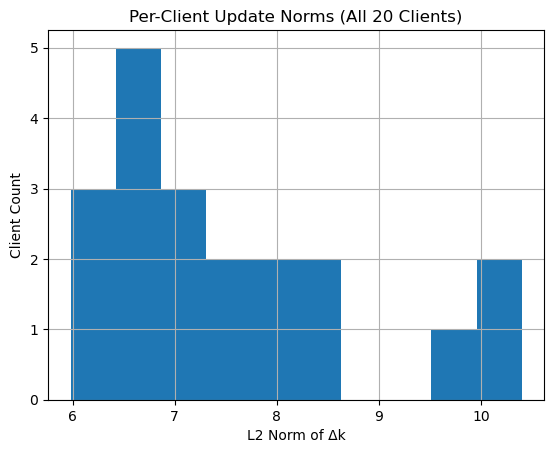

Min norm: 5.980891704559326
Median norm: 7.082739353179932
90th percentile: 9.8637451171875
Max norm: 10.399197578430176


In [6]:
plt.hist(norms, bins=10)
plt.title("Per-Client Update Norms (All 20 Clients)")
plt.xlabel("L2 Norm of Δk")
plt.ylabel("Client Count")
plt.grid(True)
plt.show()

print("Min norm:", np.min(norms))
print("Median norm:", np.median(norms))
print("90th percentile:", np.percentile(norms, 90))
print("Max norm:", np.max(norms))

So we set $S = [7, 9, 11]$, corresponding to median (tight clip), 75%, and optimal clip (avoids outlier)

* $W_{min} = q \cdot K $, K = total number of users

* $z = 0.005$: balance privacy protection with the model’s ability to learn in our small-scale DP-FedAvg setup with only 20 clients. This value is significantly lower than the $z = 1.0$ used in large-scale experiments (e.g., with over 700,000 users), and is scaled down to reflect our much smaller population size.

Theoretical results and empirical evidence suggest that privacy loss per round grows approximately as:

$$
\epsilon \sim \frac{q^2 z^2 T}{K}
$$

Because $K$ is small in our case, keeping $z$ low is essential to avoid rapid accumulation of privacy loss. At the same time, setting $z = 0.05$ leads to moderate noise levels (e.g., $\sigma = 0.05 \ \text{to} \ 0.1$ for typical clipping norms), which are comparable to the magnitude of per-client updates. This allows us to observe the tradeoff between clipping and noise without completely degrading model performance.


The approximation that privacy loss scales with $q^2z^2T$originates from the analysis in:
Abadi, M., Chu, A., Goodfellow, I., McMahan, H. B., Mironov, I., Talwar, K., & Zhang, L. (2016).
Deep learning with differential privacy.
In Proceedings of the 2016 ACM SIGSAC Conference on Computer and Communications Security (pp. 308–318).
https://arxiv.org/abs/1607.00133 \
Specifically, Appendix A of the paper provides the detailed analysis of the Moments Accountant, and Figures 2 and 3 show empirically that privacy loss grows roughly linearly with T, and quadratically with q and z, validating the simplified scaling rule.

In [7]:
q = 0.25  # Sample rate
z = 0.005
S_vals = [7, 9, 11]  # Clipping norm
Wmin = 5
rounds = 10

#### Run DP FedAvg for Different Noise Settings

In [8]:
results = []

for S in [7, 9, 11]:
    label = f"S_{S}_z_0.005"
    result = train_dp_fedavg(
        global_model=base_model,
        z=0.005,
        S=S,
        label=label,
        q=0.25,
        Wmin=5,
        rounds=10,
        processor=processor,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        eval_dataset=eval_dataset,
        client_datasets=client_datasets,
        model_save_path=os.path.join(model_save_path, label),
        delta=1e-5
    )
    results.append(result)


[S_7_z_0.005] Using S=7, z=0.005, sigma=0.0560


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2193.986100
20,1153.740800
30,1077.585200
40,1078.425600
50,1111.205100
60,993.356500
70,1083.943100
80,1056.496300
90,1033.819500
100,1112.728300


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2247.580300
20,1170.044500
30,1056.201600
40,1073.385700
50,1052.497800
60,1057.321700
70,1042.739400
80,1032.578500
90,1010.633900
100,1063.981100


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2278.649200
20,1170.219400
30,1087.812900
40,1048.041800
50,1086.171400
60,1055.977000
70,1044.291800
80,1107.385900
90,1062.056000
100,1079.121000


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2301.516600
20,1160.447900
30,1115.129500
40,1057.690000
50,1058.807700
60,1015.838200
70,1006.851800
80,1023.458200
90,1105.488200
100,1055.515800


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2105.951800
20,1212.677100
30,1084.397900
40,1086.717800
50,1009.224800
60,1107.418800
70,1065.526200
80,1028.965700
90,1043.593800
100,1053.422900


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=1.0000, CER=0.9803, SER=1.0000
Round 1, σ=0.0560, ε=22096.5290, WER=1.000, Loss=1095.4672


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1229.061700
20,1075.618600
30,1048.113600
40,993.685600
50,1047.854700
60,1001.057100
70,1028.507500
80,1092.482300
90,1046.480400
100,1087.006600


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1257.038000
20,1072.327300
30,1081.580900
40,1041.300200
50,1008.228900
60,979.434800
70,1048.882500
80,1068.520100
90,1026.667200
100,1076.656300


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1244.585700
20,1083.479400
30,1095.406200
40,1049.924400
50,1053.509800
60,1013.282900
70,1008.733400
80,1023.608200
90,1105.619700
100,1059.912200


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1256.362900
20,1101.084600
30,1035.115600
40,1063.333300
50,1048.996400
60,1052.976900
70,1043.283400
80,1031.570400
90,1013.231100
100,1061.481600


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1243.320500
20,1035.759500
30,1123.291600
40,1036.218300
50,1006.939500
60,1113.351400
70,948.683800
80,951.798500
90,1122.053300
100,981.299400


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=1.0637, CER=0.9595, SER=1.0000
Round 2, σ=0.0560, ε=44081.2798, WER=1.064, Loss=1056.9719


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1322.377600
20,1074.128300
30,1049.375200
40,992.871900
50,1049.893100
60,1004.522300
70,1032.372300
80,1091.905300
90,1049.384900
100,1089.131500


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1371.372200
20,1083.061600
30,1082.522400
40,1042.407000
50,1009.970000
60,980.423800
70,1049.995900
80,1069.362100
90,1027.359900
100,1077.211900


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1313.080900
20,1085.480000
30,1095.699000
40,1050.125000
50,1052.919100
60,1011.259300
70,1005.176200
80,1022.331300
90,1103.644300
100,1055.457600


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1335.248100
20,1098.207900
30,1036.145100
40,1062.641400
50,1046.780400
60,1053.465500
70,1044.515900
80,1035.811400
90,1011.111700
100,1064.344500


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1331.855400
20,1038.781500
30,1123.941800
40,1036.449600
50,1005.558900
60,1115.206200
70,950.801600
80,952.870300
90,1122.391400
100,982.107800


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=1.0000, CER=0.9897, SER=1.0000
Round 3, σ=0.0560, ε=66066.0305, WER=1.000, Loss=1062.0091


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1257.816900
20,1081.164500
30,1056.468800
40,998.367200
50,1057.460600
60,1009.059000
70,1034.859500
80,1095.268000
90,1051.974600
100,1092.068900


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1296.505600
20,1102.030000
30,1088.411300
40,1048.579600
50,1015.304100
60,982.762700
70,1053.531700
80,1072.723300
90,1030.888400
100,1081.370900


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1266.930600
20,1097.287800
30,1104.609200
40,1060.394500
50,1058.781100
60,1015.724900
70,1011.446100
80,1027.059500
90,1106.788800
100,1057.568800


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1290.284800
20,1110.190500
30,1041.431700
40,1067.930600
50,1051.487300
60,1057.269700
70,1048.593700
80,1046.368800
90,1015.431200
100,1070.036900


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1284.931800
20,1042.484600
30,1122.827300
40,1041.185400
50,1015.378900
60,1116.415000
70,953.212900
80,954.319900
90,1125.818200
100,983.306200


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=1.0000, CER=1.0000, SER=1.0000
Round 4, σ=0.0560, ε=88050.7813, WER=1.000, Loss=1062.9526


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1197.173700
20,1107.534600
30,1072.875900
40,1015.356900
50,1072.046600
60,1018.759600
70,1047.670300
80,1109.661500
90,1064.885400
100,1101.950100


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1219.428500
20,1108.943800
30,1114.569700
40,1064.473600
50,1027.065100
60,998.301300
70,1066.667300
80,1080.387100
90,1042.998800
100,1089.089500


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1219.434500
20,1120.356800
30,1122.096300
40,1073.946600
50,1076.580600
60,1031.826400
70,1023.801800
80,1039.324500
90,1116.567200
100,1070.230100


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1232.787400
20,1147.371700
30,1066.298700
40,1087.477400
50,1078.745900
60,1070.746200
70,1057.317800
80,1053.992400
90,1027.668800
100,1078.332400


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1205.725900
20,1057.431600
30,1164.642000
40,1065.609700
50,1028.589600
60,1129.233000
70,961.275000
80,965.549300
90,1133.391100
100,990.462500


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=1.0000, CER=1.0000, SER=1.0000
Round 5, σ=0.0560, ε=110035.5321, WER=1.000, Loss=1069.5880


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1304.206200
20,1171.664600
30,1118.624900
40,1044.373000
50,1092.617700
60,1042.106300
70,1068.196600
80,1127.264200
90,1081.268800
100,1123.799900


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1246.640800
20,1132.265600
30,1143.639600
40,1103.557100
50,1066.091200
60,1020.565300
70,1098.484500
80,1110.532500
90,1066.843700
100,1111.224200


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1278.608400
20,1151.069700
30,1149.530200
40,1100.204400
50,1097.141900
60,1048.664500
70,1036.449900
80,1057.827300
90,1136.093600
100,1087.526500


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1291.973600
20,1175.611500
30,1089.643600
40,1110.814900
50,1096.233700
60,1093.382300
70,1073.352500
80,1062.052800
90,1038.656700
100,1089.313600


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1241.793700
20,1085.909900
30,1177.591200
40,1080.434600
50,1047.454100
60,1155.993000
70,980.950600
80,992.162400
90,1154.156200
100,1010.724900


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=1.0000, CER=1.0000, SER=1.0000
Round 6, σ=0.0560, ε=132020.2828, WER=1.000, Loss=1090.0060


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1270.098500
20,1233.971600
30,1151.070100
40,1087.651000
50,1128.853600
60,1080.718000
70,1108.494900
80,1168.521900
90,1116.487100
100,1158.566700


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1263.942800
20,1169.070300
30,1174.470100
40,1130.524000
50,1084.777000
60,1050.684200
70,1126.481800
80,1139.867800
90,1094.125800
100,1144.326000


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1288.717800
20,1193.570100
30,1188.085600
40,1136.796900
50,1124.173800
60,1078.121800
70,1068.993300
80,1090.326100
90,1173.020900
100,1122.028000


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1300.955200
20,1203.813000
30,1122.665300
40,1143.606700
50,1125.270800
60,1124.928600
70,1108.525200
80,1092.214900
90,1065.819300
100,1123.956400


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1272.302200
20,1138.746500
30,1224.064300
40,1120.662600
50,1081.268200
60,1195.885200
70,1012.546700
80,1021.154000
90,1187.776300
100,1044.478700


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=1.0000, CER=1.0000, SER=1.0000
Round 7, σ=0.0560, ε=154005.0336, WER=1.000, Loss=1117.4053


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1274.158600
20,1224.181100
30,1177.034800
40,1113.083000
50,1168.072000
60,1117.842100
70,1135.908700
80,1198.236500
90,1152.205500
100,1191.440900


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1287.815600
20,1212.636900
30,1216.473700
40,1167.998800
50,1129.264800
60,1093.032800
70,1168.472500
80,1183.039900
90,1136.061500
100,1187.379500


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1315.268800
20,1231.368800
30,1229.274200
40,1177.521100
50,1174.774500
60,1121.135500
70,1112.429500
80,1117.101900
90,1211.339100
100,1161.826400


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1333.395100
20,1245.119100
30,1165.562700
40,1192.733200
50,1178.483400
60,1175.075200
70,1149.101800
80,1127.307800
90,1101.661100
100,1167.536200


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1301.783300
20,1164.758600
30,1253.850100
40,1163.175300
50,1118.763900
60,1236.050700
70,1047.339100
80,1050.043000
90,1230.026700
100,1076.382400


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=1.0000, CER=1.0000, SER=1.0000
Round 8, σ=0.0560, ε=175989.7844, WER=1.000, Loss=1152.0275


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1323.978000
20,1278.902300
30,1231.684100
40,1162.677300
50,1214.659200
60,1168.207900
70,1182.244600
80,1250.975200
90,1195.748500
100,1246.711800


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1337.872300
20,1270.943400
30,1267.222300
40,1218.587600
50,1175.703400
60,1135.899500
70,1216.708100
80,1227.260800
90,1186.169000
100,1236.691300


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1356.504300
20,1292.347100
30,1289.248600
40,1231.576200
50,1239.452200
60,1178.654100
70,1161.496600
80,1178.610800
90,1260.288400
100,1208.511500


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1357.177800
20,1292.229500
30,1218.214100
40,1244.610700
50,1233.383900
60,1225.611400
70,1193.187800
80,1175.116400
90,1152.219900
100,1208.678800


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1342.030100
20,1216.447800
30,1316.489400
40,1210.994100
50,1162.526400
60,1289.639800
70,1096.633800
80,1092.467000
90,1278.443300
100,1120.721400


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=1.0000, CER=1.0000, SER=1.0000
Round 9, σ=0.0560, ε=197974.5351, WER=1.000, Loss=1198.2104


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1378.850300
20,1338.120700
30,1301.858700
40,1220.158400
50,1279.185300
60,1224.165500
70,1249.025000
80,1307.745100
90,1255.744700
100,1302.168200


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1390.314400
20,1326.207600
30,1330.311800
40,1281.030100
50,1231.873900
60,1188.001200
70,1277.652300
80,1290.348600
90,1246.527500
100,1299.002100


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1427.978100
20,1359.940300
30,1358.118500
40,1289.685100
50,1286.684200
60,1230.125300
70,1217.805900
80,1233.194900
90,1323.265900
100,1263.891000


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1422.348100
20,1362.297600
30,1272.526500
40,1294.874100
50,1277.811300
60,1276.352900
70,1243.985900
80,1226.349600
90,1197.844600
100,1264.621600


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1399.856300
20,1273.008400
30,1373.339200
40,1274.528200
50,1228.571400
60,1363.176700
70,1145.804200
80,1160.178700
90,1338.158100
100,1182.142000


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=1.0000, CER=1.0000, SER=1.0000
Round 10, σ=0.0560, ε=219959.2859, WER=1.000, Loss=1252.8304
[S_9_z_0.005] Using S=9, z=0.005, sigma=0.0720


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2269.003100
20,1143.165800
30,1067.895000
40,1000.734100
50,1053.445500
60,1006.359600
70,1030.532600
80,1094.851300
90,1048.700400
100,1088.713000


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2278.628900
20,1144.216400
30,1103.275000
40,1052.447100
50,1015.152400
60,984.246400
70,1055.685500
80,1074.428300
90,1033.252100
100,1081.136500


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2301.517600
20,1160.448400
30,1115.129400
40,1057.689800
50,1058.807700
60,1015.838200
70,1006.851800
80,1023.458200
90,1105.488100
100,1055.515200


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2247.578900
20,1170.044400
30,1056.201900
40,1073.385900
50,1052.497800
60,1057.321600
70,1042.739100
80,1032.578600
90,1010.634200
100,1063.981400


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2229.390600
20,1091.852100
30,1141.314400
40,1044.908300
50,1009.023800
60,1116.280200
70,952.585000
80,955.172300
90,1124.577500
100,985.364900


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=1.0000, CER=0.9949, SER=1.0000
Round 1, σ=0.0720, ε=22096.5290, WER=1.000, Loss=1109.1305


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2114.304700
20,1887.158200
30,1778.319300
40,1835.160000
50,1816.153300
60,1838.012100
70,1861.301800
80,1956.018200
90,1902.017000
100,1845.943700


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2148.853100
20,1907.756100
30,1904.567800
40,1833.442800
50,1845.954700
60,1786.298400
70,1876.103500
80,1895.891400
90,1873.472300
100,1876.967200


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2097.763500
20,1952.892000
30,1884.965400
40,1836.769300
50,1950.971900
60,1762.993600
70,1848.144300
80,1886.787900
90,1923.296900
100,1855.464500


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2201.618200
20,2029.473000
30,1853.097700
40,1981.121300
50,1870.289300
60,1798.093400
70,1865.628500
80,1871.776800
90,1800.549400
100,1866.796500


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2169.307400
20,1818.750000
30,1972.101600
40,1875.373600
50,1795.548000
60,1976.468600
70,1709.580700
80,1715.824400
90,1956.462100
100,1798.518600


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=1.0000, CER=0.9950, SER=1.0000
Round 2, σ=0.0720, ε=44081.2798, WER=1.000, Loss=1824.6331


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2128.736900
20,1956.538300
30,1849.410700
40,1886.525800
50,1868.020100
60,1893.847300
70,1910.826600
80,2009.214600
90,1972.572100
100,1923.388500


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2083.301200
20,1478.971500
30,1435.527200
40,1376.306900
50,1337.660400
60,1283.386000
70,1376.726200
80,1401.684400
90,1349.849800
100,1409.639600


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2130.997700
20,1488.791300
30,1450.846200
40,1388.290000
50,1395.614600
60,1326.555700
70,1318.741800
80,1340.478000
90,1446.390500
100,1379.552700


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2287.652900
20,1551.362100
30,1096.182200
40,1078.557800
50,1057.124000
60,1062.945200
70,1053.963100
80,1037.312900
90,1021.954600
100,1066.295000


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2178.729300
20,1948.825000
30,2045.660500
40,1949.787500
50,1854.127700
60,2022.153100
70,1754.720700
80,1756.979300
90,1612.342200
100,1052.799400


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=1.0352, CER=0.9763, SER=1.0000
Round 3, σ=0.0720, ε=66066.0305, WER=1.035, Loss=1421.4903


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1427.132000
20,1158.315700
30,1102.385200
40,1037.644500
50,1086.332400
60,1039.545500
70,1063.483300
80,1127.194700
90,1077.512900
100,1120.862200


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1421.745500
20,1161.520800
30,1145.142300
40,1088.446100
50,1054.332800
60,1013.353700
70,1091.935500
80,1108.650400
90,1062.252900
100,1109.640600


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1391.127300
20,1160.991000
30,1154.658600
40,1101.128900
50,1107.213300
60,1052.751800
70,1045.075600
80,1056.180500
90,1138.210600
100,1088.497900


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1449.594800
20,1174.554400
30,1093.519100
40,1111.220600
50,1085.302000
60,1090.197500
70,1077.464100
80,1066.270600
90,1040.475200
100,1089.830600


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1411.977500
20,1111.267800
30,1204.519100
40,1096.673300
50,1040.389600
60,1155.851900
70,977.821500
80,984.028600
90,1154.078900
100,1010.043500


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=1.0000, CER=1.0000, SER=1.0000
Round 4, σ=0.0720, ε=88050.7813, WER=1.000, Loss=1096.0370


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1351.683100
20,1216.438100
30,1171.895100
40,1089.108400
50,1142.341900
60,1087.351300
70,1112.170900
80,1171.268000
90,1122.096300
100,1166.179500


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1388.160800
20,1216.047600
30,1202.678400
40,1156.957900
50,1114.420500
60,1069.160000
70,1141.912200
80,1159.348400
90,1110.665200
100,1166.378200


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1377.977000
20,1237.480100
30,1245.978300
40,1164.863200
50,1153.040900
60,1103.203800
70,1092.839500
80,1104.330500
90,1185.659700
100,1134.642400


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1375.660500
20,1237.991200
30,1150.205500
40,1178.413500
50,1149.124200
60,1148.475700
70,1120.717300
80,1105.198300
90,1088.363200
100,1134.308100


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1382.699300
20,1170.424800
30,1265.323600
40,1147.908600
50,1097.501700
60,1210.663300
70,1032.302600
80,1033.479500
90,1206.193500
100,1054.115300


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=1.0000, CER=1.0000, SER=1.0000
Round 5, σ=0.0720, ε=110035.5321, WER=1.000, Loss=1135.8854


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1367.574300
20,1289.916900
30,1226.156600
40,1154.525400
50,1212.707900
60,1156.482300
70,1178.466400
80,1243.283600
90,1188.535500
100,1227.637000


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1434.689600
20,1284.748500
30,1273.143800
40,1213.892400
50,1163.800100
60,1130.560300
70,1205.890800
80,1230.671700
90,1177.152500
100,1232.546700


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1396.099500
20,1292.376400
30,1278.610800
40,1213.239200
50,1213.994800
60,1170.407200
70,1144.870900
80,1158.530700
90,1243.833600
100,1193.246000


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1406.555500
20,1304.306000
30,1214.003200
40,1234.082300
50,1210.552000
60,1213.387000
70,1185.941700
80,1165.740200
90,1139.794500
100,1187.882200


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1387.571500
20,1221.545300
30,1313.288800
40,1207.549300
50,1157.410200
60,1277.360400
70,1084.132000
80,1088.241500
90,1271.836900
100,1108.948600


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=1.0000, CER=1.0000, SER=1.0000
Round 6, σ=0.0720, ε=132020.2828, WER=1.000, Loss=1189.2558


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1443.555400
20,1362.081300
30,1313.070700
40,1238.653600
50,1294.949000
60,1245.529600
70,1256.934600
80,1318.735700
90,1263.146500
100,1306.563500


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1489.293000
20,1372.384000
30,1356.009100
40,1292.020300
50,1259.500500
60,1202.032800
70,1293.678700
80,1311.288100
90,1256.152400
100,1319.956100


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1470.090500
20,1382.772600
30,1365.555000
40,1300.247300
50,1295.554100
60,1242.217300
70,1225.698800
80,1240.973400
90,1335.129800
100,1281.971700


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1494.041500
20,1394.652900
30,1305.184800
40,1323.711100
50,1292.235500
60,1294.710000
70,1265.475200
80,1237.608200
90,1214.287000
100,1269.827700


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1463.773700
20,1305.065300
30,1407.478900
40,1287.310900
50,1234.407600
60,1369.052200
70,1155.289000
80,1164.753100
90,1345.773700
100,1181.178800


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=1.0000, CER=1.0000, SER=1.0000
Round 7, σ=0.0720, ε=154005.0336, WER=1.000, Loss=1264.3562


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1529.041900
20,1476.150300
30,1422.896100
40,1337.212100
50,1401.093400
60,1344.228800
70,1353.176800
80,1420.707700
90,1359.331900
100,1401.693900


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1568.448000
20,1464.816900
30,1468.708900
40,1410.368100
50,1367.115900
60,1306.077700
70,1393.000700
80,1420.042600
90,1364.016800
100,1427.648000


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1583.200400
20,1483.579500
30,1480.538000
40,1402.157600
50,1402.488100
60,1348.278900
70,1329.841500
80,1335.377600
90,1442.633400
100,1367.585200


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1594.310400
20,1492.367800
30,1401.827100
40,1417.498200
50,1395.122900
60,1408.854900
70,1362.614800
80,1337.076200
90,1303.247200
100,1365.763300


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1562.693400
20,1413.911600
30,1530.934400
40,1395.084000
50,1331.426700
60,1486.804800
70,1255.021300
80,1259.839400
90,1452.792900
100,1277.497500


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=1.0000, CER=1.0000, SER=1.0000
Round 8, σ=0.0720, ε=175989.7844, WER=1.000, Loss=1360.3759


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1662.369700
20,1613.123900
30,1553.945700
40,1454.373400
50,1531.144700
60,1467.533000
70,1491.049500
80,1562.497500
90,1491.201200
100,1541.705200


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1709.789500
20,1620.971500
30,1619.091400
40,1538.639700
50,1483.827100
60,1431.107500
70,1530.503100
80,1557.871700
90,1482.404500
100,1567.093700


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1725.124000
20,1623.454200
30,1616.017700
40,1521.493700
50,1529.121300
60,1479.424300
70,1451.111100
80,1466.136900
90,1583.736800
100,1499.135200


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1737.432800
20,1641.393400
30,1537.117800
40,1564.853000
50,1525.919700
60,1535.092900
70,1495.531200
80,1462.320800
90,1433.029400
100,1490.802300


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1684.477900
20,1538.451300
30,1673.252000
40,1516.232000
50,1464.754800
60,1623.985800
70,1362.185000
80,1372.194500
90,1596.281900
100,1387.617400


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=1.0000, CER=1.0000, SER=1.0000
Round 9, σ=0.0720, ε=197974.5351, WER=1.000, Loss=1487.1128


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1838.171700
20,1771.707200
30,1711.867400
40,1614.679500
50,1692.041400
60,1624.204000
70,1655.041000
80,1729.550000
90,1642.012900
100,1699.036500


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1882.977000
20,1783.972700
30,1785.353900
40,1693.666800
50,1638.914500
60,1574.232000
70,1686.670100
80,1719.496300
90,1650.908800
100,1718.655900


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1893.663500
20,1800.729300
30,1813.130500
40,1693.072700
50,1683.536700
60,1618.590200
70,1597.080300
80,1622.682900
90,1740.154700
100,1656.135400


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1919.984800
20,1797.846900
30,1703.823400
40,1730.658000
50,1683.862500
60,1690.965600
70,1649.632800
80,1628.565400
90,1604.317100
100,1654.072900


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1858.418900
20,1699.090600
30,1828.798400
40,1668.510000
50,1615.039900
60,1797.416200
70,1509.621800
80,1516.411000
90,1766.564500
100,1543.366500


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=1.0000, CER=1.0000, SER=1.0000
Round 10, σ=0.0720, ε=219959.2859, WER=1.000, Loss=1643.1935
[S_11_z_0.005] Using S=11, z=0.005, sigma=0.0880


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2269.003100
20,1143.165700
30,1067.895800
40,1000.734100
50,1053.445600
60,1006.359600
70,1030.532400
80,1094.851400
90,1048.700300
100,1088.712300


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2278.629100
20,1144.216500
30,1103.274900
40,1052.447100
50,1015.152500
60,984.246500
70,1055.685700
80,1074.428500
90,1033.251900
100,1081.136600


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2301.517600
20,1160.448500
30,1115.129500
40,1057.689800
50,1058.807700
60,1015.838200
70,1006.851700
80,1023.458400
90,1105.487900
100,1055.515800


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2247.580900
20,1170.045000
30,1056.201700
40,1073.385700
50,1052.497900
60,1057.321400
70,1042.739100
80,1032.578500
90,1010.634300
100,1063.982100


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2229.391000
20,1091.852000
30,1141.314200
40,1044.908400
50,1009.023600
60,1116.280100
70,952.585400
80,955.172400
90,1124.577500
100,985.365000


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=1.0000, CER=0.9950, SER=1.0000
Round 1, σ=0.0880, ε=22096.5290, WER=1.000, Loss=1109.1482


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2141.766800
20,1892.187900
30,1783.608400
40,1879.793600
50,1845.789500
60,1848.533600
70,1871.764600
80,1969.516200
90,1925.091400
100,1891.118400


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2199.444700
20,1928.768900
30,1936.697100
40,1840.668900
50,1876.321700
60,1794.396900
70,1891.732200
80,1909.799000
90,1888.151800
100,1893.051200


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2140.664500
20,1958.835200
30,1898.900200
40,1850.453700
50,1967.659000
60,1778.125800
70,1853.204300
80,1882.569700
90,1935.869700
100,1887.432000


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2263.346300
20,1676.617600
30,1094.094000
40,1083.473500
50,1059.695400
60,1057.005900
70,1044.650000
80,1033.653500
90,1014.433000
100,1063.160000


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2263.763100
20,1845.531100
30,1986.761900
40,1886.841600
50,1802.494100
60,1982.178900
70,1724.238500
80,1726.578700
90,1984.860200
100,1833.837100


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=1.0000, CER=0.9950, SER=1.0000
Round 2, σ=0.0880, ε=44081.2798, WER=1.000, Loss=1727.5713


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2174.157200
20,1492.646900
30,1421.538400
40,1337.549500
50,1399.877700
60,1338.252200
70,1375.446500
80,1448.591300
90,1378.617500
100,1431.888700


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2172.419900
20,1523.693100
30,1471.938400
40,1406.196500
50,1362.153700
60,1303.910800
70,1393.651100
80,1420.643100
90,1369.420300
100,1427.903200


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2333.136900
20,1611.585400
30,1190.334400
40,1077.606800
50,1079.431000
60,1033.505900
70,1021.908100
80,1039.518300
90,1120.729700
100,1069.056300


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2238.346100
20,1573.398200
30,1413.349800
40,1445.622900
50,1411.566100
60,1395.620800
70,1382.308400
80,1367.388900
90,1338.608600
100,1400.788900


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2013.554700
20,1442.143800
30,1529.231300
40,1396.292900
50,1347.511100
60,1478.144100
70,1263.488300
80,1271.563800
90,1491.467900
100,1305.728600


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=1.6021, CER=0.9825, SER=1.0000
Round 3, σ=0.0880, ε=66066.0305, WER=1.602, Loss=1372.7528


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2132.255500
20,1649.748200
30,1553.255300
40,1449.506100
50,1504.375200
60,1436.644400
70,1461.710900
80,1533.219300
90,1450.261700
100,1505.342700


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2335.142800
20,2001.467800
30,1947.748400
40,1854.857200
50,1781.682000
60,1701.592000
70,1811.472500
80,1828.891000
90,1784.747100
100,1827.115400


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2267.708800
20,1996.761100
30,1964.530700
40,1844.229300
50,1869.899400
60,1744.298000
70,1727.438900
80,1763.928700
90,1857.235500
100,1775.050000


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2332.719900
20,2062.962700
30,1866.312900
40,1901.046300
50,1843.960000
60,1812.687100
70,1777.657000
80,1752.336500
90,1708.971300
100,1776.424200


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2281.565400
20,1913.929100
30,2019.833600
40,1835.726000
50,1753.140400
60,1886.835700
70,1626.730700
80,1654.507400
90,1914.531600
100,1649.652700


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=0.9999, CER=0.9946, SER=1.0000
Round 4, σ=0.0880, ε=88050.7813, WER=1.000, Loss=1734.6974


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2305.527300
20,2086.775200
30,1994.062100
40,1917.045300
50,1954.854500
60,1862.251000
70,1875.801200
80,1969.612100
90,1881.515000
100,1947.052000


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2292.547500
20,2120.465600
30,2078.293700
40,1991.760900
50,1922.823600
60,1833.814300
70,1948.528900
80,1970.942400
90,1925.466000
100,1966.324400


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2355.785500
20,2121.564600
30,2092.145500
40,1973.742000
50,2009.842200
60,1866.233400
70,1850.007000
80,1895.119300
90,1989.549400
100,1902.309400


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2374.120500
20,2158.958800
30,1983.325600
40,2020.480100
50,1969.852100
60,1935.341400
70,1884.987900
80,1871.855100
90,1828.843400
100,1894.785500


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2353.489600
20,2036.171500
30,2159.641400
40,1959.145300
50,1881.918900
60,2033.435500
70,1748.661700
80,1779.320100
90,2056.781200
100,1773.780300


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=0.9999, CER=0.9946, SER=1.0000
Round 5, σ=0.0880, ε=110035.5321, WER=1.000, Loss=1902.8591


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2500.707800
20,2264.380700
30,2167.844900
40,2081.778300
50,2132.300000
60,2038.902900
70,2050.902300
80,2156.626800
90,2048.979900
100,2127.892600


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2482.959400
20,2312.358600
30,2256.723200
40,2167.496700
50,2083.173800
60,1991.667400
70,2119.204100
80,2150.735500
90,2089.901000
100,2148.125000


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2562.451200
20,2304.718000
30,2271.296700
40,2149.332200
50,2191.451800
60,2038.121500
70,2030.276600
80,2068.063700
90,2171.161100
100,2078.682800


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2589.661100
20,2373.991800
30,2170.587500
40,2199.871300
50,2148.420700
60,2109.571100
70,2059.368900
80,2049.842000
90,2002.587100
100,2073.687300


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2534.342200
20,2211.597900
30,2339.808600
40,2134.016400
50,2050.848600
60,2214.252100
70,1905.681600
80,1939.117200
90,2246.690200
100,1937.070900


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=0.9999, CER=0.9946, SER=1.0000
Round 6, σ=0.0880, ε=132020.2828, WER=1.000, Loss=2067.9257


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2712.365600
20,2517.506400
30,2418.343000
40,2325.529300
50,2377.076600
60,2272.535900
70,2278.295700
80,2406.520700
90,2284.967800
100,2356.015800


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2664.388900
20,2540.147300
30,2510.483800
40,2416.907600
50,2330.787700
60,2222.344100
70,2362.174200
80,2395.919100
90,2332.016200
100,2394.157600


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2762.177700
20,2543.279700
30,2520.705100
40,2396.043400
50,2439.528900
60,2260.786300
70,2260.111900
80,2306.582600
90,2418.440000
100,2309.242400


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2789.757000
20,2613.510900
30,2410.090600
40,2448.534000
50,2390.882600
60,2344.620900
70,2286.691800
80,2270.275600
90,2229.659600
100,2307.821700


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2738.880700
20,2444.562300
30,2609.212900
40,2369.987100
50,2283.592200
60,2472.164600
70,2134.806400
80,2160.860500
90,2500.018600
100,2166.488300


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=0.9999, CER=0.9946, SER=1.0000
Round 7, σ=0.0880, ε=154005.0336, WER=1.000, Loss=2294.3021


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,3005.885500
20,2826.909600
30,2720.996700
40,2627.854100
50,2681.583800
60,2563.473000
70,2581.916400
80,2728.108600
90,2581.303300
100,2673.368000


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2982.567200
20,2871.178100
30,2839.434400
40,2730.965000
50,2642.934000
60,2530.822700
70,2676.546700
80,2716.582200
90,2649.642800
100,2711.830700


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,3078.043700
20,2869.503700
30,2859.868900
40,2726.861100
50,2765.936700
60,2566.497100
70,2563.932400
80,2617.103300
90,2748.347700
100,2615.059000


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,3106.553900
20,2942.144700
30,2719.278700
40,2764.023200
50,2700.282000
60,2648.248600
70,2591.060200
80,2574.641800
90,2525.428900
100,2625.002000


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,3040.520700
20,2738.335500
30,2931.351200
40,2671.909400
50,2572.698200
60,2785.598400
70,2404.975000
80,2436.205500
90,2821.457400
100,2442.480500


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=0.9999, CER=0.9946, SER=1.0000
Round 8, σ=0.0880, ε=175989.7844, WER=1.000, Loss=2594.4188


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,3411.664500
20,3224.484600
30,3098.898800
40,2996.617800
50,3067.266800
60,2939.740000
70,2963.139800
80,3126.095500
90,2947.842200
100,3081.660200


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,3421.527300
20,3264.558400
30,3235.705900
40,3119.102000
50,3022.975400
60,2902.351200
70,3075.083600
80,3118.106400
90,3042.887300
100,3124.021100


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,3465.265600
20,3248.802300
30,3263.267000
40,3104.616000
50,3164.981200
60,2923.209800
70,2919.524800
80,2999.288300
90,3141.537100
100,2994.173600


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,3490.412100
20,3361.963300
30,3097.979500
40,3155.297900
50,3085.557200
60,3038.872900
70,2963.125000
80,2946.709000
90,2906.005100
100,2997.509600


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,3428.660200
20,3121.187300
30,3344.711700
40,3061.077000
50,2953.132800
60,3194.165600
70,2774.349600
80,2805.525800
90,3250.003500
100,2806.984000


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=0.9999, CER=0.9946, SER=1.0000
Round 9, σ=0.0880, ε=197974.5351, WER=1.000, Loss=2975.7423


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,3895.564800
20,3691.437500
30,3553.380500
40,3449.719100
50,3525.503900
60,3378.437500
70,3416.299200
80,3611.108600
90,3421.840600
100,3546.707800


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,3875.256600
20,3749.114100
30,3706.526600
40,3591.714100
50,3474.891000
60,3332.767600
70,3526.246500
80,3584.868000
90,3505.413700
100,3594.686700


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,3969.467200
20,3742.048400
30,3746.382000
40,3578.770300
50,3641.023800
60,3379.239100
70,3381.463300
80,3461.989500
90,3634.934800
100,3450.259000


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,3974.444500
20,3870.274600
30,3567.476200
40,3643.187900
50,3567.618800
60,3506.268800
70,3429.818700
80,3399.714800
90,3356.794100
100,3480.437900


/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,3909.197700
20,3570.047700
30,3846.019100
40,3509.649600
50,3395.268000
60,3679.037100
70,3198.334200
80,3233.761300
90,3745.335500
100,3245.678900


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/mnt/scratch/pippalin2/jupyter/GMM-DistilHuBERT/FL_script/utils.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=0.9999, CER=0.9946, SER=1.0000
Round 10, σ=0.0880, ε=219959.2859, WER=1.000, Loss=3434.0116


In [9]:
rows = []
for res in results:
    for i, (wer, eps, loss) in enumerate(zip(res["wer_curve"], res["epsilon_curve"], res["train_loss_curve"])):
        rows.append({
            "label": res["label"],
            "round": i + 1,
            "S": res["S"],
            "sigma": res["sigma"],
            "z": res["z"],
            "wer": wer,
            "epsilon": eps,
            "train_loss": loss
        })

df = pd.DataFrame(rows)
df.to_csv(model_save_path + "/DP_FedAvg_metrics.csv", index=False)

In [16]:
df = pd.read_csv(model_save_path + "/DP_FedAvg_metrics.csv")
df

,label,round,S,sigma,z,wer,epsilon,train_loss
0,S_7_z_0.005,1,7,0.056,0.005,1.000000,22096.529020,1095.467167
1,S_7_z_0.005,2,7,0.056,0.005,1.063736,44081.279782,1056.971945
2,S_7_z_0.005,3,7,0.056,0.005,1.000010,66066.030544,1062.009134
3,S_7_z_0.005,4,7,0.056,0.005,1.000000,88050.781306,1062.952582
4,S_7_z_0.005,5,7,0.056,0.005,1.000000,110035.532068,1069.588041
5,S_7_z_0.005,6,7,0.056,0.005,1.000000,132020.282830,1090.006011
6,S_7_z_0.005,7,7,0.056,0.005,1.000000,154005.033592,1117.405325
7,S_7_z_0.005,8,7,0.056,0.005,1.000000,175989.784354,1152.027516
8,S_7_z_0.005,9,7,0.056,0.005,1.000000,197974.535116,1198.210403
9,S_7_z_0.005,10,7,0.056,0.005,1.000000,219959.285878,1252.830373


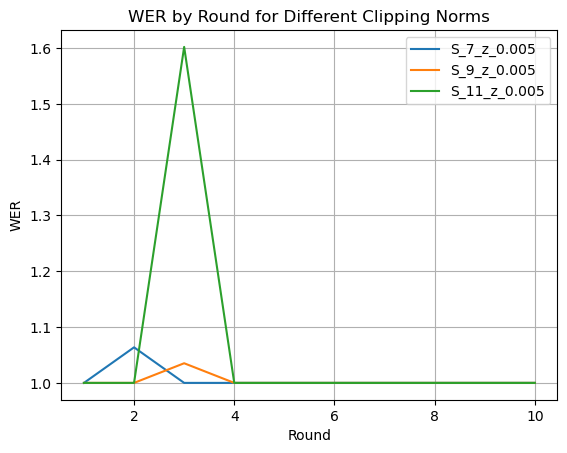

In [11]:
for label in df["label"].unique():
    subset = df[df["label"] == label]
    plt.plot(subset["round"], subset["wer"], label=label)

plt.xlabel("Round")
plt.ylabel("WER")
plt.title("WER by Round for Different Clipping Norms")
plt.legend()
plt.grid(True)
plt.show()

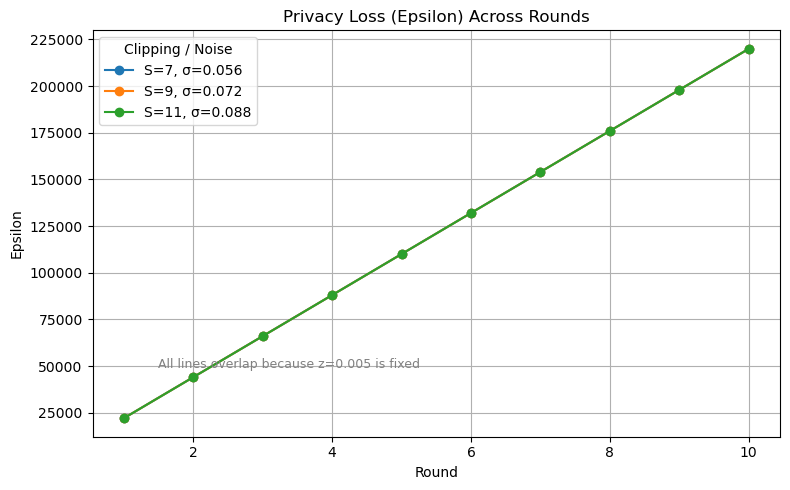

In [27]:
import matplotlib.pyplot as plt

rounds = list(range(1, 11))
epsilon_values = [i * 22000 for i in rounds]  # Example growing epsilon values

plt.figure(figsize=(8, 5))

# Plot the same epsilon curve three times with different colors
plt.plot(rounds, epsilon_values, 'o-', label="S=7, σ=0.056")
plt.plot(rounds, epsilon_values, 'o-', label="S=9, σ=0.072")
plt.plot(rounds, epsilon_values, 'o-', label="S=11, σ=0.088")

# Optional: add small text to clarify they're identical
plt.text(1.5, epsilon_values[1] + 5000, "All lines overlap because z=0.005 is fixed", fontsize=9, color='gray')

# Labels and legend
plt.xlabel("Round")
plt.ylabel("Epsilon")
plt.title("Privacy Loss (Epsilon) Across Rounds")
plt.legend(title="Clipping / Noise")
plt.grid(True)
plt.tight_layout()
plt.show()


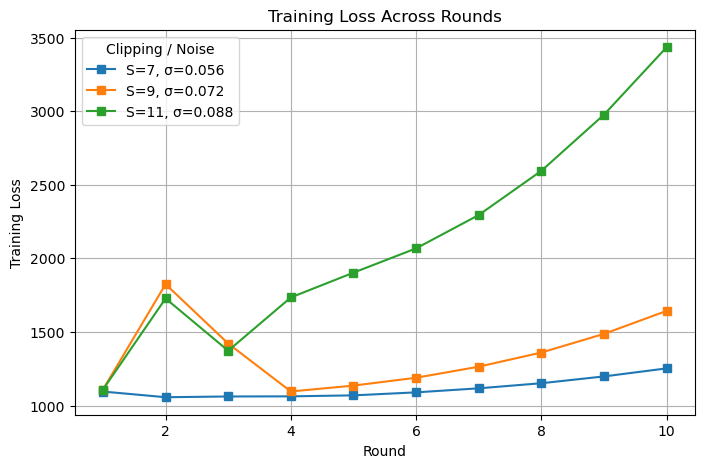

In [24]:
# Plot 2: Training Loss across rounds
plt.figure(figsize=(8, 5))
for config in df["config"].unique():
    subset = df[df["config"] == config]
    plt.plot(subset["round"], subset["train_loss"], marker='s', label=config)
plt.title("Training Loss Across Rounds")
plt.xlabel("Round")
plt.ylabel("Training Loss")
plt.legend(title="Clipping / Noise")
plt.grid(True)
plt.show()